## Dataset evaluator

此处用于数据集的分析，用于指导后续的特征工程

共分三个步骤：
1. 数据提纯（Data purify）
2. 类别分析 (Category analyse)
3. 文本分析 (Text analyse)

In [1]:
import pandas as pd
data_df = pd.read_csv("../data/spam.csv", encoding="latin-1")
data_df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


**Here are some columns unnecessary, but before `removing it`, we'd better have a check!**

In [2]:
data_df.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""",GE,"GNT:-)"""
freq,4825,30,3,2,2


In [3]:
missing_df = data_df.isnull().sum().sort_values(ascending=False).reset_index()
missing_df.head()
missing_df.columns = ['feature', 'missing_num']
missing_df.insert(loc=2, column='missing_percentage', value=missing_df['missing_num']/data_df.shape[0])
missing_df.head()

,feature,missing_num,missing_percentage
0,Unnamed: 4,5566,0.998923
1,Unnamed: 3,5560,0.997846
2,Unnamed: 2,5522,0.991027
3,v2,0,0.000000
4,v1,0,0.000000


**Since the last three columns-_"Unamed234"_ occupy only a little part-*50, 12 ,6*,**

**deleting them is reasonable.**

### Data purify

In [4]:
data_df = data_df.drop(columns=data_df.columns[2:5])
display(data_df)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


### Category analyse(类别分析)
From a macro perspective，_v1(category)'s category distribution and v2(text)'s text length_ are both obviously important features.

In this part, we'll dive into category analyse

In [5]:
categories = data_df.loc[:, 'v1']
categories.value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

Ham's count is much more greater then spam's, draw a pie chart to visualize it!

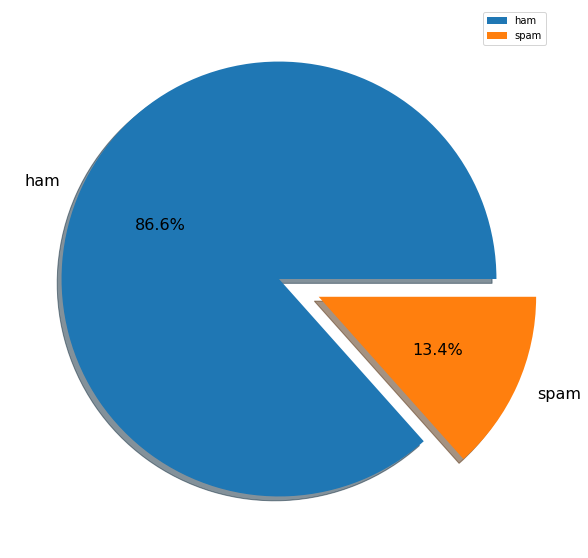

In [6]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(10,10))
categories.value_counts().plot(kind='pie', explode=[0, 0.2], shadow=True,   autopct='%1.1f%%', textprops={'fontsize': 16, 'color': 'black'})
plt.ylabel('')
plt.legend(loc='upper right')

And using dataframe.describe

In [7]:
data_df.groupby('v1').describe()

v2                                                               
     count unique                                                top freq
v1                                                                       
ham   4825   4516                             Sorry, I'll call later   30
spam   747    653  Please call our customer service representativ...    4

#### Summary for category distribution

From charts above, we can see:spam and ham 的分配比重是有显著difference，这提示我们应当注意样本unbalance的情况。失衡的样本容易引导模型走向歧路，毕竟86.6 vs 13.4之下，ham邮件出现的信息熵远低于spam邮件，一个简单的全ham预测器也能达到86.6的accuracy。

一般而言，针对于样本不均衡的措施有两大方向: **基于样本**以及**基于训练方法**

1. 在基于样本的措施中，**过采样少数类**以及**欠采样多数类**是常见的措施，但却有着过拟合、欠拟合的风险。此外还可通过1:1组合样本(均衡采样,每个Batch内保持类别样本均衡)来训练多个模型，又较为繁琐。

2. 在基于训练方法的措施中，可以通过为样本增加惩罚项（不同类别样本设置不同的权重，通常与设置成与类别数目成反比，即样本数目愈多的类，设置越低的权重）或对样本进行特征选择，前者可以通过在损失函数上进行改进，典型的有adaboost，后者则要求"较少样本"足够多以覆盖足够的特征点才能供我们提取。

但回头一想，倘若训练集的spam、ham比例符合于现实情况的真实分布呢？如此一来让模型去学习这样一种distribution不正是我们所需要的吗。况且86.6 vs 13.4,其实也并非**十分地**不均衡。

所以可以考虑去进行一些均衡化的措施，但或许并不是十分必要。

但86.6的准确率其实并不够看，我们需要提升准确率，而更重要的是去提升精确率，因为做到精准分投才是邮件自动分类所需要的。

---
### Text analyse

**Text length** is an obvious feature

In [8]:
texts = data_df.loc[:, 'v2']
texts_length = texts.apply(lambda text: len(text))

In [9]:
data_df['v3'] = texts_length
data_df.head()

,v1,v2,v3
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [10]:
ham_texts_length = data_df.loc[data_df['v1'] == 'ham', 'v3']
spam_texts_length = data_df.loc[data_df['v1'] == 'spam', 'v3']

Draw a plot via seaborn to vialize it;

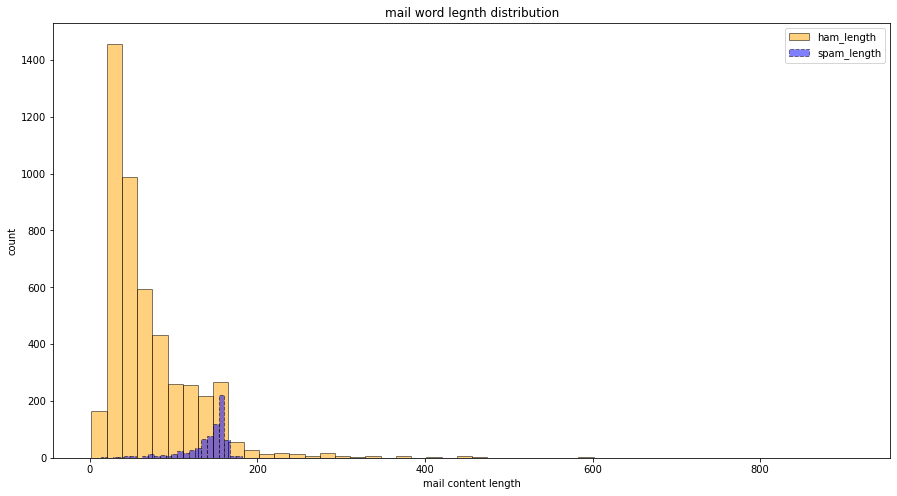

In [11]:
import seaborn as sns 
plt.figure(figsize=(15,8))
sns.distplot(ham_texts_length, bins=50, label='ham_length',  kde=False,
             hist_kws={'alpha':0.5, 'color':'orange', 'edgecolor':'black'})
sns.distplot(spam_texts_length, bins=30, label='spam_length',  kde=False,
             hist_kws={'alpha':0.5, 'color':'blue', 'edgecolor':'black', 'linestyle':'--'})
plt.xlabel('mail content length')
plt.ylabel('count')
plt.title('mail word legnth distribution')
plt.legend()

As showed above, the length distribution of ham and spam differs a lot. Even though we divide according to length, a nice score can be easily achieved.

* So length can be a key feature

---
### Dive into text

邮件的字数以及类别的分布都是值得考量的特征，但这只是从宏观来看。乃至于数据的提纯其实也是宏观层面，事实上还并没有进行微观细节的观察。因为邮件的内容是复杂的，直接拿来处理并不妥当，此外，邮件的内容也是需要考量的。根据邮件内容制定特征工程的方向是重中之重。

Here i pre-defined a helper class `TextPurifier` to assist us

In [12]:
text_msgs = data_df.loc[:, 'v2'].to_list()

In [13]:
import sys
import os
sys.path.append(os.path.abspath(".."))
from utils.preprocessing import TextPurifier

In [14]:
tp = TextPurifier(texts=text_msgs)

Powered by regular expression, here are the rules, which costs  a lot of time

In [15]:
print(tp)

Name:mailaddress, 	Rule:<(?:[0-9a-zA-Z_])+\S@[^.]+\.[a-z]{2,}>
Name:webaddress, 	Rule:<(http[s]?\://)?[a-zA-Z0-9\-\.]+\.(com|edu|gov|mil|net|org|biz|info|name|museum|us|ca|uk)(/\S*)*>
Name:phonenumber, 	Rule:<\(?[\d]{4}\)?[\s-]?[\d]{3}[\s-]?[\d]{4,}>
Name:number    , 	Rule:<\b\d+(\.\d+)?\b>
Name:punctuation, 	Rule:<[^\w\d\s]|_>
Name:two_many_spaces, 	Rule:<\s{2,}>



These rules are aimed at:

    1. mail address
    2. website address
    3. phone number
    4. ordinary number
    5. spaces bewteen words
These differs a lot in different sms mail, but can means the same thing.

So they should be replaced!

Here, 10 matched objects will be displayed in every rules

In [16]:
for rule_name, matched_strings in tp.show_iter(nums=10):
    print(f'Rule name: {rule_name:10s} \n {matched_strings}', end='\n\n')

Rule name: _mailaddress 
 ['yijue@hotmail.com', 'info@ringtoneking.co', 'tddnewsletter@emc1.co', 'info@txt82228.co', 'olowoyey@ usc.edu', 'Dorothy@kiefer.com', 'customersqueries@netvision.uk']

Rule name: _webaddress 
 ['www.dbuk.net', 'xxxmobilemovieclub.com', 'hotmail.com', 'www.areyouunique.co.uk', 'www.4-tc.biz', 'www.Ldew.com', 'club4mobiles.com', 'www.100percent-real.com', 'sextextuk.com', 'www.Ldew.com']

Rule name: _phonenumber 
 ['08452810075', '09061701461', '08002986030', '07732584351', '09061209465', '09066364589', '0800 169 6031', '09064012160', '0871277810910', '07742676969']

Rule name: _number    
 ['2', '3', '9', '900', '11', '100', '1', '2', '87077', '2']

Rule name: __punctuation 
 [',', '.', '.', '.', "'", "'", '.', "'", '!', '?']

Rule name: __two_many_spaces 
 ['  ', '  ', '  ', '  ', '  ', '  ', '  ', '  ', '  ', '  ']



**Purify it!**

In [17]:
texts = tp.purify()
texts[:20]

['go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat ',
 'ok lar joking wif u oni ',
 'free entry in number a wkly comp to win fa cup final tkts 21st may number text fa to number to receive entry question std txt rate t c s apply phonenumberover18 s',
 'u dun say so early hor u c already then say ',
 'nah i don t think he goes to usf he lives around here though',
 'freemsg hey there darling it s been number week s now and no word back i d like some fun you up for it still tb ok xxx std chgs to send å number to rcv',
 'even my brother is not like to speak with me they treat me like aids patent ',
 'as per your request melle melle oru minnaminunginte nurungu vettam has been set as your callertune for all callers press number to copy your friends callertune',
 'winner as a valued network customer you have been selected to receivea å number prize reward to claim call phonenumber claim code kl341 valid number hours only ',
 'had your mobil

#### Summary for Text Analyse

坦白说这里是最为耗时耗力的地方，也是整个预处理的最重要部分。

在此我们对文本进行了宏微观角度的分析：

1. 宏观层面，文本的长度自然是最为显见的地方，通过比较能发现，ham的平均长度是长于spam的。

2. 微观层面，假如浏览过数据集的内容自然能发现文本中充斥着一些**随机而又有明确含义的内容**，譬如电话号码、电子邮箱等。不同的邮箱有不同的地址，但其实都表达的是邮箱这个意思。针对于此，将这些内容以常量替代是有必要的。eg. a@b.com -> webaddress | 138741233 -> phonenumber

    此外便是一些**缺乏语义的内容**如标点符号等分词。此处予以消除
    
    另外考虑英文环境，句首大写的情况以及可能的句中大写也应该同化微小写。
    
    当然，`语态、指示代词`等也可能存在有'少意义'或者'多词一意'（如go went）的情况，但综合考虑这些内容可能仍是有助于判断的，因此留下。


Thus the final processed data is show below

In [18]:
from dataset import get_sms_dataset

data = get_sms_dataset()

In [19]:
data.head()

,target,message
0,0,go until jurong point crazy available only in ...
1,0,ok lar joking wif u oni
2,1,free entry in number a wkly comp to win fa cup...
3,0,u dun say so early hor u c already then say
4,0,nah i don t think he goes to usf he lives arou...


In [20]:
data.loc[:10, 'message']

0     go until jurong point crazy available only in ...
1                              ok lar joking wif u oni 
2     free entry in number a wkly comp to win fa cup...
3          u dun say so early hor u c already then say 
4     nah i don t think he goes to usf he lives arou...
5     freemsg hey there darling it s been number wee...
6     even my brother is not like to speak with me t...
7     as per your request melle melle oru minnaminun...
8     winner as a valued network customer you have b...
9     had your mobile number months or more u r enti...
10    i m gonna be home soon and i don t want to tal...
Name: message, dtype: object